# Using CNNs for MNIST Handwritten Digit Recognition

## Imports

In [22]:
# data analysis
import pandas as pd
# for linear algebra
import numpy as np
# plotting library
import matplotlib.pyplot as plt
%matplotlib inline
# Split the training data into train and validation sets
from sklearn.model_selection import train_test_split
# Evaluate our model
from sklearn.metrics import confusion_matrix

In [44]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import accuracy_score

In [24]:
PATH = "../input/"
train_file = f'{PATH}fashion-mnist_train.csv'
test_file = f'{PATH}fashion-mnist_test.csv'
output_file = "submission.csv"

## Load Data

In [25]:
# Load the csv file using numpy
data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',')
# Split training data into train and valid sets
# First argument takes all the rows and all the columns after the first
# column(labels) and second argument takes the labels (i.e first column)
x_train, x_val, y_train, y_val = train_test_split(
    data[:,1:], data[:,0], test_size=0.1)

We need to reshape the data for Keras. Since, these images are not RGB, we only have one channel at the end.

In [26]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

Each of the images in the train and valid sets have pixel values between 0 and 255. We divide these by 255 to make all the values between 0 and 1.

In [27]:
x_train = x_train.astype("float32")/255.
x_val = x_val.astype("float32")/255.

We use One-hot encoding to convert the label values(orginally, between 0-9) to a 10x1 array where each label will have one "1" and nine "0"s where "1" tells us the value of the label. 

In [28]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
#example:
print(y_train[0])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## Model

In [72]:
model = Sequential()

# Convolution layer with input image shape (28x28x1), relu activation, 
# kernel size of 3x3 and output image of size 16x16.
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu',
                 input_shape = (28, 28, 1)))
# Batch Normalization
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
# Drop 1/4th of the activations
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
# Dense(Fully Connected Layer) with output image of size 512x512
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
# We use softmax because we have more than 2 output classes
model.add(Dense(10, activation='softmax'))

## Data Augmentation

In [73]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

In [74]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-3), metrics=["accuracy"])

We train once with a smaller learning rate to ensure convergence. We then speed things up, only to reduce the learning rate by 10% every epoch.

In [75]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [78]:
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=128),
                           steps_per_epoch=500,
                           epochs=20,
                           verbose=2,
                           validation_data=(x_val, y_val),
                           callbacks=[annealer])

Epoch 1/20
 - 21s - loss: 0.3488 - acc: 0.8735 - val_loss: 0.2710 - val_acc: 0.8965
Epoch 2/20
 - 21s - loss: 0.3130 - acc: 0.8873 - val_loss: 0.2416 - val_acc: 0.9112
Epoch 3/20
 - 21s - loss: 0.2978 - acc: 0.8924 - val_loss: 0.2470 - val_acc: 0.9040
Epoch 4/20
 - 20s - loss: 0.2814 - acc: 0.8984 - val_loss: 0.2226 - val_acc: 0.9118
Epoch 5/20
 - 21s - loss: 0.2738 - acc: 0.9001 - val_loss: 0.2180 - val_acc: 0.9202
Epoch 6/20
 - 21s - loss: 0.2625 - acc: 0.9038 - val_loss: 0.1988 - val_acc: 0.9268
Epoch 7/20
 - 21s - loss: 0.2501 - acc: 0.9088 - val_loss: 0.1924 - val_acc: 0.9275
Epoch 8/20
 - 22s - loss: 0.2502 - acc: 0.9077 - val_loss: 0.2000 - val_acc: 0.9245
Epoch 9/20
 - 21s - loss: 0.2409 - acc: 0.9115 - val_loss: 0.2007 - val_acc: 0.9238
Epoch 10/20
 - 22s - loss: 0.2376 - acc: 0.9121 - val_loss: 0.1878 - val_acc: 0.9330
Epoch 11/20
 - 21s - loss: 0.2303 - acc: 0.9160 - val_loss: 0.1886 - val_acc: 0.9330
Epoch 12/20
 - 21s - loss: 0.2234 - acc: 0.9178 - val_loss: 0.1876 - val_a

## Evaluate

In [79]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.1778, final accuracy: 0.9333


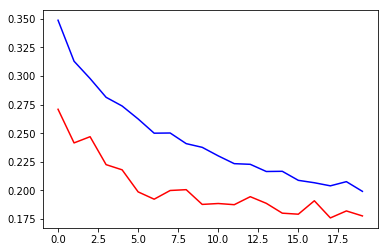

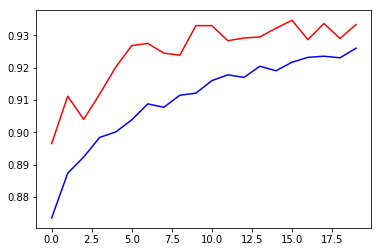

In [80]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [81]:
y_hat = model.predict(x_val)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[515   0   8   8   2   0  74   0   3   0]
 [  1 591   0   4   0   0   3   0   0   0]
 [  4   0 529   7  30   0  40   0   0   0]
 [  8   1   2 562   7   0  18   0   0   0]
 [  0   0   8  19 570   0  16   0   1   0]
 [  0   0   0   0   0 584   0   2   0   0]
 [ 34   0  18   9  29   0 501   0   2   0]
 [  0   0   0   0   0   4   0 598   0  13]
 [  0   0   0   1   0   0   1   0 588   0]
 [  0   0   0   0   0   7   0  16   0 562]]


In [82]:
mnist_testset = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')
x_test, y_test = mnist_testset[:,1:], mnist_testset[:,0]
x_test = x_test.astype("float32")
x_test = x_test.reshape(-1, 28, 28, 1)/255.

In [83]:
y_hat = model.predict(x_test, batch_size=64)

In [84]:
y_pred = np.argmax(y_hat,axis=1)

In [85]:
accuracy_score(y_test, y_pred)

0.9373